In [1]:
import warnings
warnings.filterwarnings('ignore')
import mdtraj as md 
from ase import Atoms
from nglview import show_ase
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import  GCNConv,BatchNorm,GATConv,Linear
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

In [2]:
# center the molecule at com           -> Done
# train on actual positions            -> loss not decreasing beyond 9
# loss focus more on heavy atoms       -> Done
# ignore H
# change latent space and check which is good dimension -> tried for 2,3,4 all losses are converging to 9...

In [3]:
# load water mol 
all_frames = md.load_xtc("../10_7/singlesim/it50k/eql2.xtc",top="../10_7/singlesim/it50k/conf.gro")


In [4]:
molecule = all_frames[0]
atomic_nums = [atom.element.atomic_number for atom in molecule.top.atoms] 
water = Atoms(positions= molecule.xyz[0], numbers=atomic_nums)
# show_ase(water)

In [5]:
def rotate3D(features,psi,theta,phi):
    xyz = features[:,:3]
    rest = features[:,3:]
    matrix = np.array([[np.cos(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.sin(psi),np.cos(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.sin(psi),np.sin(psi)*np.sin(theta)],
                          [-np.sin(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.cos(psi),-np.sin(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.cos(psi),np.cos(psi)*np.sin(theta)],
                            [np.sin(theta)*np.sin(phi),-np.sin(theta)*np.cos(phi),np.cos(theta)]])
    return np.concatenate((np.dot(xyz,matrix) *10 , rest),axis=1) 

In [6]:
frames = all_frames
features = []
for molecule in tqdm(frames):
    atomic_nums = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T
    vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T
    mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T
    positions = molecule.xyz[0]*10
    
    positions = positions - positions[0]
    
    node_features = np.concatenate((positions,vdwr,atomic_nums),axis=1)
    features.append(node_features)
    
features = np.array(features)

100%|██████████| 50001/50001 [00:01<00:00, 34434.79it/s]


In [7]:

# # atomic Number
# atomic_nums = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T

# # Vander wall Radii
# vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T

# # Atomic Mass 
# mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T

# atom_type = np.array([[2,1,1,0]]).T

# # Relative position of atoms on one molecule
# poitions = molecule.xyz[0]*10
# # calculate weighted average of the positions of the atoms in the molecule
# com = np.average(poitions, axis=0, weights=mass.T[0])
# # relative position of atoms in the molecule

# relative_pos = poitions-com


# print("Absolute positions:\n",poitions)
# print("\nRelative positions:\n",relative_pos)
# print("\natomic_numbers:\n",atomic_nums)
# print("\nVander wall Radii:\n", vdwr)
# print("\nAtomic Mass:\n",mass)

In [8]:
# node_features = np.concatenate((relative_pos,vdwr,atomic_nums),axis=1)
print("Node Features:\n",features[10])

Node Features:
 [[ 0.          0.          0.          0.152       8.        ]
 [-0.42058086  0.64916897  0.5638485   0.12        1.        ]
 [-0.62055779 -0.13362885 -0.71643734  0.12        1.        ]
 [-0.11106586  0.05499649 -0.01627827  0.          0.        ]]


In [9]:
from_list = []
to_list = []
for edge in all_frames.topology.bonds:
    from_list.append(edge.atom1.index)
    to_list.append(edge.atom2.index)
    from_list.append(edge.atom2.index)
    to_list.append(edge.atom1.index)

edge_list = np.array([from_list,to_list])

In [10]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [11]:
graphs = []


In [12]:
for node_feature in tqdm(features):
    graph = data.Data(x=torch.from_numpy(node_feature),edge_index=torch.from_numpy(edge_list))
    graphs.append(graph)
    

  0%|          | 0/50001 [00:00<?, ?it/s]

100%|██████████| 50001/50001 [00:00<00:00, 52827.07it/s]


In [13]:
# all_features = []
# real_node_features = []

# for i in range(n_graphs):
#     rotated = rotate3D(node_features,np.random.uniform(0,2*np.pi),np.random.uniform(0,2*np.pi),np.random.uniform(0,2*np.pi))
#     noisy_node_features = rotated + np.random.normal(0,0.1,rotated.shape)

#     all_features.append(noisy_node_features)
#     real_node_features.append(rotated)

# all_features = np.array(all_features)    
# real_node_features = np.array(real_node_features)

In [14]:
# removed Scaling/normalization

# scaler = MinMaxScaler()
# scaler.fit(all_features.reshape(-1,1))
# normalized_node_features = scaler.transform(all_features.reshape(-1,1)).reshape(all_features.shape)

# normalized_real_node_features = scaler.transform(real_node_features.reshape(-1,1)).reshape(real_node_features.shape)





In [15]:
# for x,y in zip(normalized_node_features,normalized_real_node_features):
#     graph = data.Data(x=torch.from_numpy(x),edge_index=torch.from_numpy(edge_list),y=torch.from_numpy(y))
#     graphs.append(graph)
    

In [16]:
print(graphs[0])

Data(x=[4, 5], edge_index=[2, 4])


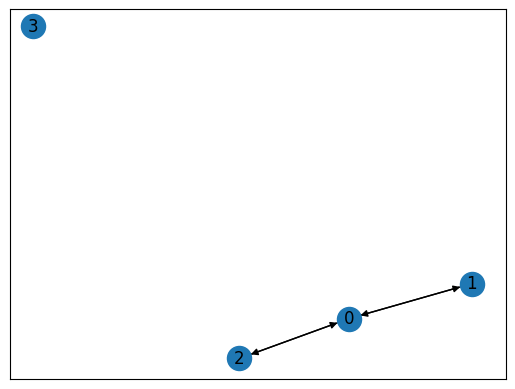

In [17]:
vis = to_networkx(graphs[0])
nx.draw_networkx(vis, with_labels=True)


In [18]:
from typing import Optional, Tuple 

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10


class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graphs_device = []
for graph in tqdm(graphs):
    graphs_device.append(graph.to(device))

100%|██████████| 50001/50001 [00:00<00:00, 174293.10it/s]


In [20]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels,batch_size,n_atoms):
        
        self.embedding_size1 = 15
        self.embedding_size2 = 9
        self.linear_size1 = 100
        self.linear_size2 = 4
        
        self.batch_size = batch_size
        self.n_atoms = n_atoms
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        super().__init__()
        self.conv1 = GATConv(self.in_channels,self.embedding_size1,heads=3)
        self.head_transform1 = Linear(self.embedding_size1*3, self.embedding_size1)
        self.bn1 = BatchNorm(self.embedding_size1)
        
        self.conv2 = GCNConv(self.embedding_size1,self.embedding_size2)
        self.bn2 = BatchNorm(self.embedding_size2)
        
        self.linear1 = Linear(self.embedding_size2, self.linear_size1)
        self.linear2 = Linear(self.linear_size1,self.linear_size2)
        
        self.transform = Linear(self.linear_size2*self.n_atoms,self.out_channels)
        
        self.mu = Linear(self.out_channels, self.out_channels)
        self.logstd = Linear(self.out_channels, self.out_channels)

    def forward(self, x, edge_index):
        self.batch_size = x.shape[0]//self.n_atoms
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)
        x = self.bn1(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        
        x = self.linear1(x)
        x = F.leaky_relu(x)

        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = x.reshape(self.batch_size,self.n_atoms,-1)
        x = x.reshape(self.batch_size,-1)
        
        x = self.transform(x)
        x = F.leaky_relu(x)
        
        
        x,y,z = self.mu(x), self.logstd(x), edge_index
        return x,y,z


In [21]:
class VariationalGCNDecoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels,batch_size,n_atoms):
        self.embedding_size1 = 9
        self.embedding_size2 = 3
        self.embedding_size3 = 3
        self.linear_size1 = 512
        self.linear_size2 = 128
        self.batch_size = batch_size
        self.n_atoms = n_atoms
        self.in_channels = in_channels
        self.out_channels = out_channels

        super().__init__()
        self.inv_transform = Linear(self.in_channels,self.n_atoms) 
        
        self.conv1 = GCNConv(1, self.embedding_size1)
        self.bn1 = BatchNorm(self.embedding_size1)

        self.conv2 = GCNConv(self.embedding_size1,self.embedding_size2)
        self.bn2 = BatchNorm(self.embedding_size2)

        self.conv3 = GCNConv(self.embedding_size2,self.embedding_size3)

        self.linear1 = Linear(self.embedding_size3, self.linear_size1)
        self.linear2 = Linear(self.linear_size1, self.linear_size2)
        self.linear3 = Linear(self.linear_size2, self.out_channels)

    def forward(self, x, edge_index, sigmoid=True):
        self.batch_size = x.shape[0]//self.n_atoms

        x = self.inv_transform(x)
        x = F.leaky_relu(x)

        x = x.reshape(x.shape[0]*x.shape[1],1)
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)        
        x = self.conv3(x,edge_index)
        
        x = self.linear1(x)
        x = F.leaky_relu(x)
        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = self.linear3(x)
        x = F.leaky_relu(x)

        
        return x, edge_index

In [22]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [23]:
import os


in_channels = graph.num_features
out_channels = 3
n_atoms = 4
lr = 1e-3
n_epochs = 500
batch_size=256
test_train_split = 0.8
model_name = "IntraGVAE_l3_final.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.exists("./models/"+model_name) and not force_train:
    model = torch.load("./models/"+model_name)
    model_loaded = True
else:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels,batch_size,n_atoms),
                VariationalGCNDecoder(out_channels, in_channels,batch_size,n_atoms))
    
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [24]:
split = int(test_train_split * len(graphs_device))
train_loader = DataLoader(graphs_device[:split], batch_size=batch_size,shuffle=True)
test_loader = DataLoader(graphs_device[split:], batch_size=batch_size,shuffle=True)

In [25]:
print("Using:",device )
print("total_graphs:", len(graphs_device))
print("Graphs in a batch:", batch_size)
print("Train Graphs Batches:",len(train_loader),f"(Total graphs: {len(train_loader)*batch_size})")
print("Test Graphs Batches:",len(test_loader),f"(Total graphs: {len(test_loader)*batch_size})")
print("Model Specifics:\n",model)

Using: cpu
total_graphs: 50001
Graphs in a batch: 256
Train Graphs Batches: 157 (Total graphs: 40192)
Test Graphs Batches: 40 (Total graphs: 10240)
Model Specifics:
 VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)


In [26]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        
        heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
     
        
        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]


        positionLoss = lossFxn(decoded_pos[heavy_indices], orignal_pos[heavy_indices])
        FeatureLoss = lossFxn(decoded_features[heavy_indices], orignal_features[heavy_indices])
        loss = lossFxn(decoded_x[heavy_indices], data.x[heavy_indices])
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)


        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)

#         positionLoss.backward()
        loss.backward()
        optimizer.step()

    return loss_all / len(train_loader), feature_loss_all / len(train_loader), edge_loss_all / len(train_loader) ,position_loss_all / len(train_loader)

In [27]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.double()
    
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]
        
        
        heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
   
        
        positionLoss = lossFxn(decoded_pos[heavy_indices], orignal_pos[heavy_indices])
        FeatureLoss = lossFxn(decoded_features[heavy_indices], orignal_features[heavy_indices])
        loss = lossFxn(decoded_x[heavy_indices], data.x[heavy_indices])

        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        
        
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)



    return loss_all / len(test_loader), feature_loss_all / len(test_loader), edge_loss_all / len(test_loader), position_loss_all / len(test_loader)

In [28]:
train_total_losses = []
train_feature_losses = []
train_edge_losses = []
train_position_losses = []

test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_position_losses = []

early_stopper = EarlyStopper(patience=3, min_delta=10)


if model_loaded:        
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):
        train_total_loss, train_feature_loss, train_edge_loss,train_position_loss = train()
        test_total_loss, test_feature_loss, test_edge_loss,test_position_loss = test()
        
        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tTotal Loss: {train_total_loss:.4f}, Feature Loss: {train_feature_loss:.4f}, Position Loss: {train_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        print(f'\tTest: \tTotal Loss: {test_total_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Position Loss: {test_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
        if(early_stopper.early_stop(test_total_loss)):
            print("Early Stopping")
            break

        train_total_losses.append(train_total_loss)
        train_feature_losses.append(train_feature_loss)
        train_edge_losses.append(train_edge_loss)
        train_position_losses.append(train_position_loss)

        test_total_losses.append(test_total_loss)
        test_feature_losses.append(test_feature_loss)
        test_edge_losses.append(test_edge_loss)
        test_position_losses.append(test_position_loss)
        
        scheduler.step()

    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	Total Loss: 0.8151, Feature Loss: 2.0344, Position Loss: 0.0022, LR: 0.001000
	Test: 	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0001, LR: 0.001000
Epoch: 002
	Train:	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0001, LR: 0.001000
	Test: 	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
Epoch: 003
	Train:	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
	Test: 	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
Epoch: 004
	Train:	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
	Test: 	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
Epoch: 005
	Train:	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
	Test: 	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, LR: 0.001000
Epoch: 006
	Train:	Total Loss: 0.0000, Feature Loss: 0.0000, Position Loss: 0.0000, L

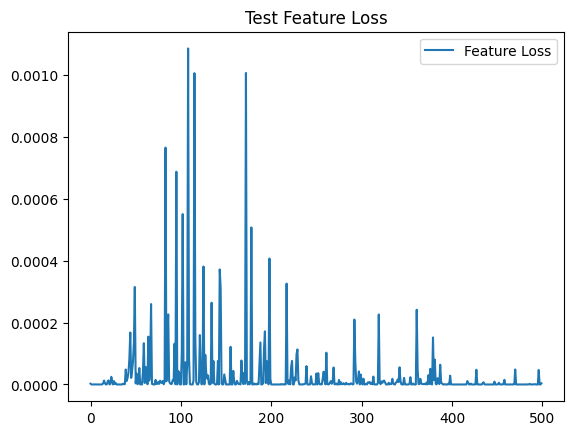

In [29]:
if not model_loaded:
    # plt.plot(test_total_losses)
    plt.plot(test_feature_losses)
    # plt.plot(edge_losses)
    # plt.plot(kl_losses)
    plt.title("Test Feature Loss")
    plt.legend(['Feature Loss', 'KL Loss'])
    plt.show()

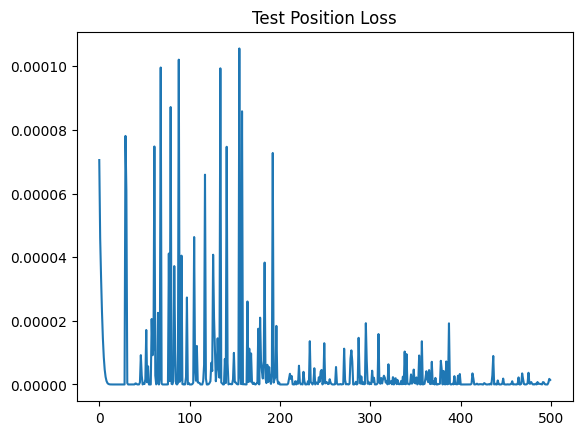

In [30]:
if not model_loaded:
    plt.plot(test_position_losses)
    plt.title("Test Position Loss")

    # atomic radius of oxygen is 0.74 Angstrom
    # atomic radius of hydrogen is 0.53 Angstrom


In [31]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

    # print("Error" , Error_wo_s, Error_af_s)

print("Average Error", avg1/len(test_loader))


Average Error 2.3862507185154633e-06


In [32]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]

(tensor([[-1.3777e-03, -1.5346e-03, -2.7414e-05,  1.5063e-01,  8.0024e+00]],
        dtype=torch.float64, grad_fn=<IndexBackward0>),
 tensor([[0.0000, 0.0000, 0.0000, 0.1520, 8.0000]], dtype=torch.float64))

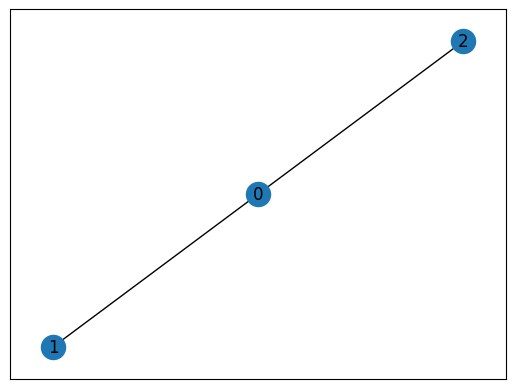

In [33]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
